In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
#projects.head(n=1)
#projects.shape
#projects.isna().sum()
#projects.apply(lambda x: x.nunique())
#projects.groupby('Project Grade Level Category')['Project ID'].count()
#projects.groupby('Project Type')['Project ID'].count()

In [2]:
projects = pd.read_csv('Original data\Projects.csv')

In [5]:
projects['Project ID'].nunique()

1110015

### Plot the top project categories

Text(0.5,1,'Top Project Categories')

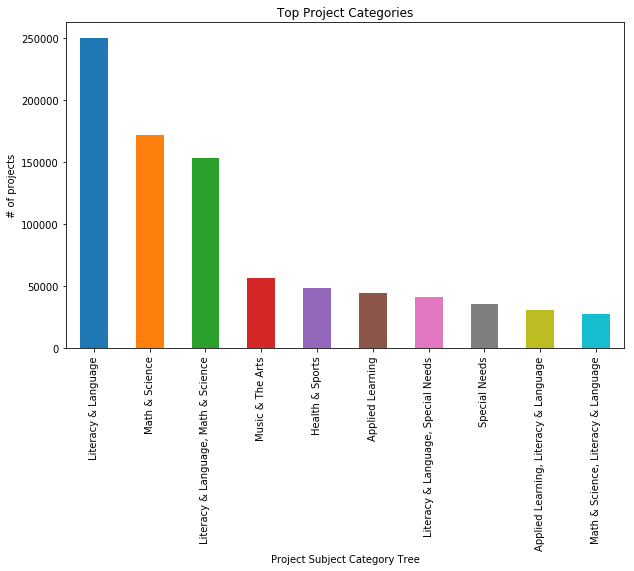

In [15]:
projects.groupby('Project Subject Category Tree')['Project ID'].count().sort_values(ascending = False)[:10].plot(kind = 'bar',\
                                                                                                                 figsize=(10, 6))
plt.ylabel('# of projects')
plt.title('Top Project Categories')

# Content Based Filtering

### a.) Creating a sample data set

In [3]:
# Read datasets
#projects = pd.read_csv('Original data\Projects.csv')
donations = pd.read_csv('Original data\Donations.csv')
donors = pd.read_csv('Original data\Donors.csv')
resources = pd.read_csv('Original data\Resources.csv')
schools = pd.read_csv('Original data\Schools.csv')
donors = pd.read_csv('Original data\Donors.csv')
teachers = pd.read_csv('Original data\Teachers.csv')

# #this piece of code converts Project_ID which is a 32-bit Hex int digits 10-1010
# # create column "project_id" with sequential integers
# f=len(projects)
# projects['project_id'] = np.nan
# g = list(range(10,f+10))
# g = pd.Series(g)
# projects['project_id'] = g.values

# Merge datasets
donations1 = donations.merge(donors, on="Donor ID", how="left")
df = donations1.merge(projects,on="Project ID", how="left")


#Create a sample from all datasets for a random sample of 50,000 donors
import random
donor_ID = tuple(df['Donor ID'].unique())
donor_ID_sample = random.sample(donor_ID, 50000)

df_sample = df[df['Donor ID'].isin(donor_ID_sample)]
# df_sample.shape = ((588334, 27))
donations_sample = donations[donations['Donation ID'].isin(df_sample['Donation ID'])]
donors_sample = donors[donors['Donor ID'].isin(df_sample['Donor ID'])]
projects_sample = projects[projects['Project ID'].isin(df_sample['Project ID'])]
resources_sample = resources[resources['Project ID'].isin(df_sample['Project ID'])]
schools_sample = schools[schools['School ID'].isin(df_sample['School ID'])]
teachers_sample = teachers[teachers['Teacher ID'].isin(df_sample['Teacher ID'])]

print (df_sample.columns)
print ('donations:',donations_sample.shape,'\n','donors:',donors_sample.shape,'\n','projects:',projects_sample.shape,'\n',\
      'resources:',resources_sample.shape,'\n','schools:',schools_sample.shape,'\n','teachers:',teachers_sample.shape,'\n',\
      'df_sample:',df_sample.shape)

C:\Users\garga\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exporting sample data to csv

In [6]:
# donations_sample.to_csv(r'Datasets\Sample\Donations.csv')
# donors_sample.to_csv(r'Datasets\Sample\Donors.csv')
# projects_sample.to_csv(r'Datasets\Sample\Projects.csv')
# resources_sample.to_csv(r'Datasets\Sample\Resources.csv')
# schools_sample.to_csv(r'Datasets\Sample\Schools.csv')
# teachers_sample.to_csv(r'Datasets\Sample\Teachers.csv')
# df_sample.to_csv(r'Datasets\Sample\df_sample.csv')

## Importing sample data from csv

In [6]:
df_sample = pd.read_csv('df_sample.csv')
projects_sample = pd.read_csv('Projects.csv')

In [3]:
#number of times a donor has donated - total number of donors for each such value
print (df_sample.groupby('Donor ID')['Donation ID'].count().value_counts().head())
print (df_sample.groupby(['Donor ID','Project ID'])['Donation ID'].count().value_counts().head())

1    36395
2     6832
3     2419
4     1212
5      733
Name: Donation ID, dtype: int64
1    87068
2     4759
3     1222
4      553
5      329
Name: Donation ID, dtype: int64


In [8]:
import math
# Deal with missing values
df_sample["Donation Amount"] = df_sample["Donation Amount"].fillna(0)

# Define event strength as the donated amount to a certain project
df_sample['eventStrength'] = df_sample['Donation Amount']

def smooth_donor_preference(x):
    return math.log(1+x, 2)
    
donations_full_df = df_sample \
                    .groupby(['Donor ID', 'Project ID'])['eventStrength'].sum() \
                    .apply(smooth_donor_preference).reset_index()
donations_full_df.head()

,Donor ID,Project ID,eventStrength
0,00008eec5aab2228652e22457881f2d0,24e7552d1a01bc2bfaaa1fef2fa42d28,5.672425
1,000110c8c5db5d760b313292dbfb24d1,845824318021765a8b3cfcb66c3169c9,4.700440
2,0001abd0c3f256bcdbc75116f2609355,06b1b00c918886cd4850c8ae1bae2d1c,4.700440
3,00027d3b680199e9350bc20fd2454a02,7e538ce993723396701312add5ac935f,4.700440
4,0004f42bf17585076f354d58485129be,e680292474d3073beb6c202c50783ef9,5.672425


In [5]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
#donations full df is a unique combination of a donor and a project. 
#Does not contain multiple donations by a donor to the same project.

donations_train_df, donations_test_df = train_test_split(donations_full_df, test_size=0.20, random_state=42)

print('# donations on Train set: %d' % len(donations_train_df))
print('# donations on Test set: %d' % len(donations_test_df))

#Indexing by Donor Id to speed up the searches during evaluation
donations_full_indexed_df = donations_full_df.set_index('Donor ID')
donations_train_indexed_df = donations_train_df.set_index('Donor ID')
donations_test_indexed_df = donations_test_df.set_index('Donor ID')

# donations on Train set: 75534
# donations on Test set: 18884


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing of text data
textfeats = ["Project Title","Project Essay"]
for cols in textfeats:
    projects_sample[cols] = projects_sample[cols].astype(str) 
    projects_sample[cols] = projects_sample[cols].astype(str).fillna('') # FILL NA
    projects_sample[cols] = projects_sample[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
 
text = projects_sample["Project Title"] + ' ' + projects_sample["Project Essay"]
vectorizer = TfidfVectorizer(strip_accents='unicode',
                             analyzer='word',
                             lowercase=True, # Convert all uppercase to lowercase
                             stop_words='english', # Remove commonly found english words ('it', 'a', 'the') which do not typically contain much signal
                             max_df = 0.9, # Only consider words that appear in fewer than max_df percent of all documents
                             # max_features=5000 # Maximum features to be extracted                    
                            )                        
project_ids = projects_sample['Project ID'].tolist()  #length = 327,439
tfidf_matrix = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()

In [7]:
#Build Donor Profile
import scipy
import sklearn 

def get_project_profile(project_id):
    idx = project_ids.index(project_id)
    project_profile = tfidf_matrix[idx:idx+1]
    return project_profile

def get_project_profiles(ids):
    project_profiles_list = [get_project_profile(x) for x in np.ravel([ids])]
    project_profiles = scipy.sparse.vstack(project_profiles_list)
    return project_profiles

def build_donors_profile(donor_id, donations_indexed_df):
    donations_donor_df = donations_indexed_df.loc[donor_id] #get all donations for a given donor
    donor_project_profiles = get_project_profiles(donations_donor_df['Project ID']) #get project profiles for the list of those donations
    donor_project_strengths = np.array(donations_donor_df['eventStrength']).reshape(-1,1) #get event stregth between each project and donor
    #Weighted average of project profiles by the donations strength
    donor_project_strengths_weighted_avg = np.sum(donor_project_profiles.multiply(donor_project_strengths), axis=0) / (np.sum(donor_project_strengths)+1)
    donor_profile_norm = sklearn.preprocessing.normalize(donor_project_strengths_weighted_avg)
    return donor_profile_norm

from tqdm import tqdm

#building donors profile for all donors using all projects
def build_donors_profiles(): 
    donations_indexed_df = donations_full_df[donations_full_df['Project ID'].isin(projects_sample['Project ID'])].set_index('Donor ID')
    donor_profiles = {}
    for donor_id in tqdm(donations_indexed_df.index.unique()):
        donor_profiles[donor_id] = build_donors_profile(donor_id, donations_indexed_df)
    return donor_profiles

donor_profiles = build_donors_profiles()
print("# of donors with profiles: %d" % len(donor_profiles))

100%|██████████| 50000/50000 [06:00<00:00, 138.65it/s]


# of donors with profiles: 50000


## Extract the top 100 donors

In [69]:
frequent_donors = df_sample['Donor ID'].value_counts().sort_values(ascending = False)[:10].reset_index()
list_frequent_donors = list(frequent_donors['index'])

Text(0.5,0,'Donors')

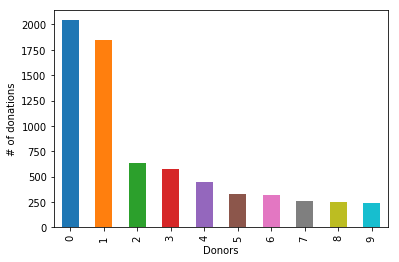

In [70]:
frequent_donors['Donor ID'][:10].plot(kind = 'bar')
plt.ylabel('# of donations')
plt.xlabel('Donors')

#### Total amount donated by top 100 donors

In [49]:
donations_amt_df = pd.DataFrame(columns = ['DonorID','donation_amt'])
for donor in list_frequent_donors:
    donation_amt = df_sample[df_sample['Donor ID'] == donor]['eventStrength'].sum()
    donations_amt_df.loc[len(donations_amt_df)] = [donor,donation_amt]

Text(0.5,1,'Total donations by top donors')

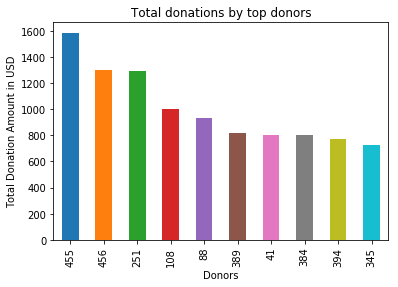

In [71]:
donations_amt_df['donation_amt'].sort_values(ascending = False)[:10].plot(kind='bar')
plt.ylabel('Total Donation Amount in USD')
plt.xlabel('Donors')
plt.title('Total donations by top donors')

Text(0.5,1,'Total donations by donors ranked 90-100')

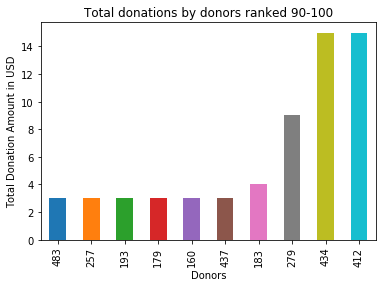

In [51]:
donations_amt_df['donation_amt'].sort_values(ascending = True)[:10].plot(kind='bar')
plt.ylabel('Total Donation Amount in USD')
plt.xlabel('Donors')
plt.title('Total donations by donors ranked 90-100')

## Creating class to identify cosine similarities and recommend projects 

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, projects_df=None):
        self.project_ids = project_ids
        self.projects_df = projects_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_projects_to_donor_profile(self, donor_id, topn=100):
        #Computes the cosine similarity between the donor profile and all project profiles
        cosine_similarities = cosine_similarity(donor_profiles[donor_id], tfidf_matrix)
        #Gets the top similar projects
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar projects by similarity
        similar_projects = sorted([(project_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_projects
    
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10, verbose=False):
        similar_projects = self._get_similar_projects_to_donor_profile(donor_id)
        #Ignores projects the donor has already donated
        similar_projects_filtered = list(filter(lambda x: x[0] not in projects_to_ignore, similar_projects))
        
        recommendations_df = pd.DataFrame(similar_projects_filtered, columns=['Project ID', 'recStrength']).head(topn)

        recommendations_df = recommendations_df.merge(self.projects_df, how = 'left', 
                                                    left_on = 'Project ID', 
                                                    right_on = 'Project ID')[['recStrength', 'Project ID', 'Project Title', 'Project Essay']]


        return recommendations_df

## Comparing the top 10 recommendations for 100 donors with their actual donations

In [73]:
recommended_match_count = pd.DataFrame(columns = ['DonorID','Match_count'])
for donor in list_frequent_donors:
    mydonor1 = donor
    mydonor1_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[mydonor1].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token', 'relevance'])
    # Creating the instance of class ContentBasedRecommender
    cbr_model = ContentBasedRecommender(projects_sample)
    top_projects_recommended = cbr_model.recommend_projects(mydonor1)['Project ID']
    projects_actually_donated = df_sample[df_sample['Donor ID'] == donor]['Project ID'].unique()
    count = 0
    for top_project in top_projects_recommended:
        if top_project in projects_actually_donated:
            count = count + 1 
    recommended_match_count.loc[len(recommended_match_count)] = [donor,count]    

In [54]:
print('Average match rate of top 10 recommendations against actual donations is ',recommended_match_count['Match_count'].mean())

Average match rate of top 10 recommendations against actual donations is  2.622


In [18]:
recommended_match_count.to_csv('Content_based_filtering_recommendations_match_rate.csv')

## 2 Examples to show that the donors for whom we have enough past data, content based filtering seems to work really well 

In [75]:
#for donor in list_frequent_donors:
mydonor1 = frequent_donors['index'][0]
mydonor1_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[mydonor1].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token', 'relevance'])
print(mydonor1_profile)

# Creating the instance of class ContentBasedRecommender
cbr_model = ContentBasedRecommender(projects_sample)
top_projects_recommended = cbr_model.recommend_projects(mydonor1)['Project Title']


       token  relevance
0     school   0.189307
1       help   0.158243
2   learning   0.158216
3    project   0.146039
4      learn   0.127768
5  classroom   0.118686
6   military   0.116404
7      class   0.114764
8       make   0.110813
9    college   0.110792


In [38]:
top_projects_recommended.to_csv('top_projects_recommended_1.csv')

In [68]:
#for donor in list_frequent_donors:
mydonor1 = frequent_donors['index'][100]
mydonor1_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[mydonor1].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token', 'relevance'])
print(mydonor1_profile)

# Creating the instance of class ContentBasedRecommender
cbr_model = ContentBasedRecommender(projects_sample)
top_projects_recommended = cbr_model.recommend_projects(mydonor1)['Project Title']

        token  relevance
0     tablets   0.481746
1  technology   0.209758
2  integrated   0.194816
3      access   0.184066
4   available   0.183301
5        asus   0.158103
6   classroom   0.150564
7      online   0.147908
8        kids   0.141414
9       great   0.140309


In [66]:
print(top_projects_recommended)

0                      technology for my first graders
1                          tablets to improve reading 
2                          technology to keep current!
3          tablets for mrs. baker's second grade class
4    we're fired up for technology: amazon fire tab...
5               limitless "app"ortunities with tablets
6                            tablets for the 5th grade
7      technology in the classroom makes learning fun!
8    intuitive technology with tablets for esl stud...
9    feeding the fire (additional amazon fire tablets)
Name: Project Title, dtype: object


# Testing the accuracy of content based recommendation system

In [43]:
def get_projects_donated(donor_id, donations_df):
    # Get the donor's data and merge in the movie information.
    try:
        donated_projects = donations_df.loc[donor_id]['Project ID']
        return set(donated_projects if type(donated_projects) == pd.Series else [donated_projects])
    except KeyError:
        return []

#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_PROJECTS = 100

class ModelEvaluator:

    def get_not_donated_projects_sample(self, donor_id, sample_size, seed=42):
        donated_projects = get_projects_donated(donor_id, donations_full_indexed_df)
        all_projects = set(projects_sample['Project ID'])
        non_donated_projects = all_projects - donated_projects

        #random.seed(seed)
        non_donated_projects_sample = random.sample(non_donated_projects, sample_size)
        return set(non_donated_projects_sample)

    def _verify_hit_top_n(self, project_id, recommended_projects, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_projects) if c == project_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_donor(self, model, donor_id):
        #Getting the projects in test set
        donated_values_testset = donations_test_indexed_df.loc[donor_id]
        if type(donated_values_testset['Project ID']) == pd.Series:
            donor_donated_projects_testset = set(donated_values_testset['Project ID'])
        else:
            donor_donated_projects_testset = set([donated_values_testset['Project ID']])  
        donated_projects_count_testset = len(donor_donated_projects_testset) 

        #Getting a ranked recommendation list from a model for a given donor
        donor_recs_df = model.recommend_projects(donor_id,\
                                                 projects_to_ignore=get_projects_donated(donor_id,\
                                                                                         donations_train_indexed_df),\
                                                 topn=100000)

        hits_at_3_count = 0
        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each project the donor has donated in test set
        for project_id in donor_donated_projects_testset:
            #Getting a random sample (100) projects the donor has not donated 
            #(to represent projects that are assumed to be no relevant to the donor)
            non_donated_projects_sample = self.get_not_donated_projects_sample(donor_id,\
                                                                               sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_PROJECTS,\
                                                                               seed=42)

            #Combining the current donated project with the 100 random projects
            projects_to_filter_recs = non_donated_projects_sample.union(set([project_id]))

            #Filtering only recommendations that are either the donated project or from a random sample of 100 non-donated projects
            valid_recs_df = donor_recs_df[donor_recs_df['Project ID'].isin(projects_to_filter_recs)]                    
            valid_recs = valid_recs_df['Project ID'].values
            #Verifying if the current donated project is among the Top-N recommended projects
            hit_at_3, index_at_3 = self._verify_hit_top_n(project_id, valid_recs, 3)
            hits_at_3_count += hit_at_3
            hit_at_5, index_at_5 = self._verify_hit_top_n(project_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(project_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the donated projects that are ranked among the Top-N recommended projects, 
        #when mixed with a set of non-relevant projects
        recall_at_3 = hits_at_3_count / float(donated_projects_count_testset)
        recall_at_5 = hits_at_5_count / float(donated_projects_count_testset)
        recall_at_10 = hits_at_10_count / float(donated_projects_count_testset)

        donor_metrics = {'hits@3_count':hits_at_3_count, 
                         'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'donated_count': donated_projects_count_testset,
                          'recall@3': recall_at_3,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return donor_metrics

    # Function to take the entire model as input.
    def evaluate_model(self, model):
        #print('Running evaluation for donors')
        people_metrics = []
        for idx, donor_id in enumerate(list(donations_test_indexed_df.index.unique().values)):
            #print ('hello')
            #if idx > 200:
                #print('%d donors processed' % idx)
                #break;
            donor_metrics = self.evaluate_model_for_donor(model, donor_id)  
            donor_metrics['_donor_id'] = donor_id
            people_metrics.append(donor_metrics)
        print('%d donors processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('donated_count', ascending=False)
        
        global_recall_at_3 = detailed_results_df['hits@3_count'].sum() / float(detailed_results_df['donated_count'].sum())
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['donated_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['donated_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@3': global_recall_at_3,
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        # Returning global_metrics and detailed results_df
        return global_metrics, detailed_results_df
    
# Creating the instance of class ModelEvaluator
model_evaluator = ModelEvaluator()

In [44]:
print('Evaluating Content-Based Filtering model...')

# Calling evaluate_model function in the class. Pass the content based recommendation model we created above.
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(cbr_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df = cb_detailed_results_df[['_donor_id', 'donated_count', "hits@3_count", 'hits@5_count','hits@10_count', 
                                                'recall@3','recall@5','recall@10']]
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
13391 donors processed

Global metrics:
{'modelName': 'Content-Based', 'recall@3': 0.8320271128998094, 'recall@5': 0.8320271128998094, 'recall@10': 0.8320271128998094}


,_donor_id,donated_count,hits@3_count,hits@5_count,hits@10_count,recall@3,recall@5,recall@10
122,67cb61233835275f98075521d5afa420,233,6,6,6,0.025751,0.025751,0.025751
89,0d90f689080b0d740a62a51c7f362829,212,20,20,20,0.094340,0.094340,0.094340
10,1d74dad1dc92b0ba0b6a787d3a793612,116,0,0,0,0.000000,0.000000,0.000000
449,8d275299cdaa27a714f0e49588edf641,82,3,3,3,0.036585,0.036585,0.036585
469,6f5ee119c72627f4078e0f63cc4a1fdc,63,0,0,0,0.000000,0.000000,0.000000
284,f0ea78ff6ce64e89e929948a60ea09d9,61,0,0,0,0.000000,0.000000,0.000000
932,4b9004c4531d6c0c10aa2fe10cd4cbaa,52,1,1,1,0.019231,0.019231,0.019231
184,090bdfd4bc540d85623ae2ad597c393c,48,1,1,1,0.020833,0.020833,0.020833
209,533bb08d99eaa177339004b1c613e002,46,0,0,0,0.000000,0.000000,0.000000
104,7e1f1954f5332107f5e87c5c4742c227,42,1,1,1,0.023810,0.023810,0.023810


In [30]:
cb_detailed_results_df.head(10)

NameError: name 'cb_detailed_results_df' is not defined

# Collaborative Filtering

### Step 1: Create donor-project matrix

In [35]:
#Creating a sparse pivot table with donors in rows and projects in columns
donors_projects_pivot_matrix_df = donations_full_df_sample.pivot(index='Donor ID',\
                                                          columns='Project ID',\
                                                          values='eventStrength').fillna(0)\

MemoryError: 

In [42]:
donors_projects_pivot_matrix_df = donations_full_df_sample.pivot(index = 'Donor ID',columns = 'Project ID',values='eventStrength').fillna(0)

In [37]:
donations_full_df_sample = donations_full_df[:10000]

In [51]:

donors_projects_pivot_matrix_df.iloc[30].sum()

5.672425341971496

In [53]:
unique_donors = donations_full_df['Donor ID'].unique()